# AMICI Python example "splines"

This is an example showing how to add spline assignment rules to a pre-existing SBML model.

Let us consider the following SBML model:

```xml
<?xml version="1.0" encoding="UTF-8"?>
<sbml xmlns="http://www.sbml.org/sbml/level2/version5" level="2" version="5">
  <model id="example_splines">
    <listOfCompartments>
      <compartment id="compartment" size="1"/>
    </listOfCompartments>
    <listOfSpecies>
      <species id="x" compartment="compartment" initialAmount="0"/>
    </listOfSpecies>
    <listOfParameters>
      <parameter id="f" constant="false"/>
    </listOfParameters>
    <listOfRules>
      <rateRule variable="x">
        <math xmlns="http://www.w3.org/1998/Math/MathML">
          <ci> f </ci>
        </math>
      </rateRule>
    </listOfRules>
  </model>
</sbml>
```

This model corresponds to the simple ODE $\dot{x} = f$ for a species $x$ and a parameter $f$.

We can easily import and simulate this model in AMICI.

In [1]:
import os
import sys
import importlib

import numpy as np
import sympy as sp

import libsbml
import amici

from matplotlib import pyplot as plt

In [2]:
# remove previous models
import shutil
shutil.rmtree('build', ignore_errors=True)
os.mkdir('build')

In [3]:
def simulate(sbml_model, parameters=None, T=1):
    if parameters is None:
        parameters = {}
    # Create build dir
    from uuid import uuid1
    suffix = uuid1().hex
    
    build_dir = os.path.join('build', suffix)
    module_name = 'example_splines_' + suffix
    # Build the model module from the SBML file
    sbml_importer = amici.SbmlImporter(sbml_model)
    sbml_importer.sbml2amici(module_name, build_dir)
    # Import the model module
    sys.path.insert(0, os.path.abspath(build_dir))
    model_module = importlib.import_module(module_name)
    # Setup simulation timepoints and parameters
    model = model_module.getModel()
    for (name, value) in parameters.items():
        model.setParameterByName(name, value)
    model.setTimepoints(np.linspace(0, T, 100))
    solver = model.getSolver()
    solver.setSensitivityOrder(amici.SensitivityOrder.first)
    solver.setSensitivityMethod(amici.SensitivityMethod.forward)
    # Simulate
    rdata = amici.runAmiciSimulation(model, solver)
    # Plot results
    fig, ax = plt.subplots()
    ax.plot(rdata['t'], rdata['x'])
    return model, rdata

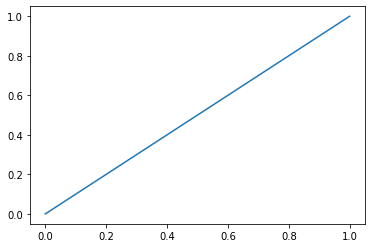

In [4]:
simulate('example_splines.xml', dict(f=1));

Instead of using a constant parameter $f$, we want to use a smooth time-dependent function $f(t)$ whose value is known only at a finite number of time instants. The value of $f(t)$ outside such grid points needs to be smoothly interpolated. Several methods have been developed for this problem over the years; AMICI at the moment supports only cubic Hermite splines.

We can add a spline function to an existing SBML model with the following code. The resulting time-dependent parameter $f(t)$ will assume values $(1, -0.5, 2)$ at the equally spaced points $(0, 0.5, 1)$ and smoothly vary elsewhere.

AMICI encodes the spline as a SBML assignment rule for the parameter $f$. Such a rule consists of a piecewise-polynomial formula which can be interpreted in any SBML-compliant software. However, such very complex formulas are computationally inefficient; e.g., in AMICI they lead to very long model creation times. To solve such problem the above code adds AMICI-specific SBML annotations to the assignment rule which can be used by AMICI to recreate the correct interpolant without reading the inefficient piecewise formula.

In [5]:
# Create a spline object
spline = amici.splines.CubicHermiteSpline(
    sbml_id='f',
    x=amici.sbml_utils.amici_time_symbol, # the spline function is evaluated at the current time point
    xx=amici.splines.UniformGrid(0, 1, length=3),
    yy=[1, -1, 2],
)   

In [6]:
# This spline object can be evaluated at any point
# and so can its derivative/integral
print(spline.evaluate(0.3))
print(spline.derivative(0.3))
print(spline.integrate(0.0, 1.0))

-0.560000000000000
-4.60000000000000
0.0416666666666672


In [7]:
def plot_spline(spline, parameters=None, xlim=None):
    if parameters is None:
        parameters = {}
    if xlim is None:
        xx = np.asarray(spline.xx)
        xlim = (float(xx[0]), float(xx[-1]))
    xx = np.linspace(*xlim, 100)
    fig, ax = plt.subplots()
    ax.plot(xx, [float(spline.evaluate(x).subs(parameters)) for x in xx])

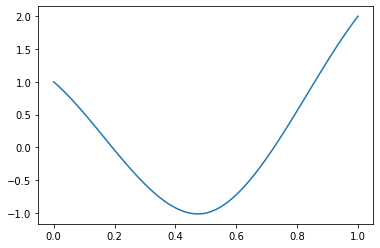

In [8]:
# Plot the spline
plot_spline(spline)

In [9]:
# Load SBML model using libsbml
sbml_doc = libsbml.SBMLReader().readSBML('example_splines.xml')
sbml_model = sbml_doc.getModel()
# We can add the spline assignment rule to the SBML model
spline.add_to_sbml_model(sbml_model)

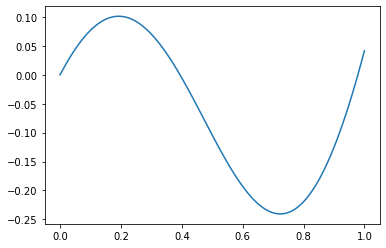

In [10]:
# Finally, we can simulate it in AMICI
model, rdata = simulate(sbml_model);

In [11]:
# Final value should be equal to the integral computed above
assert np.allclose(rdata['x'][-1], float(spline.integrate(0.0, 1.0)))

Instead of constant values, SBML parameters can be used as spline values. These can also be automatically added to the model when adding the assignment rule.

In [12]:
spline = amici.splines.CubicHermiteSpline(
    sbml_id='f',
    x=amici.sbml_utils.amici_time_symbol,
    xx=amici.splines.UniformGrid(0, 1, length=3),
    yy=sp.symbols('f0:3'),
)

In [13]:
sbml_doc = libsbml.SBMLReader().readSBML('example_splines.xml')
sbml_model = sbml_doc.getModel()
spline.add_to_sbml_model(
    sbml_model,
    auto_add=True,
    y_nominal=[1, -0.5, 2],
)

In [14]:
parameters = dict(f0=-2, f1=1, f2=-2)

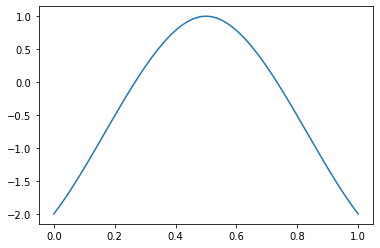

In [15]:
plot_spline(spline, parameters)

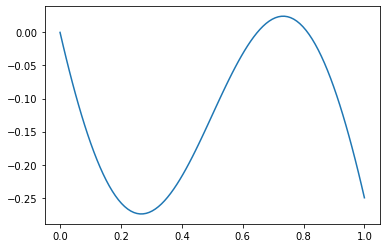

In [16]:
model, rdata = simulate(sbml_model, parameters)

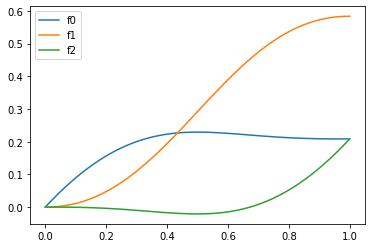

In [17]:
# Sensitivities with respect to the spline values can be computed
fig, ax = plt.subplots()
ax.plot(rdata['t'], rdata.sx[:, 0], label=model.getParameterNames()[0])
ax.plot(rdata['t'], rdata.sx[:, 1], label=model.getParameterNames()[1])
ax.plot(rdata['t'], rdata.sx[:, 2], label=model.getParameterNames()[2])
ax.legend();

When derivatives are not specified in the `CubicHermiteSpline` constructor, they are computed automatically according to the boundary conditions. The default boundary conditions depend on the extrapolation method (which defaults to no extrapolation).

For example, below we have a spline with constant extrapolation.

In [18]:
spline = amici.splines.CubicHermiteSpline(
    sbml_id='f',
    x=amici.sbml_utils.amici_time_symbol,
    xx=amici.splines.UniformGrid(0, 1, length=3),
    yy=[-2, 1, -1],
    extrapolate=(None, 'constant'), # no extrapolation required on the left side
)

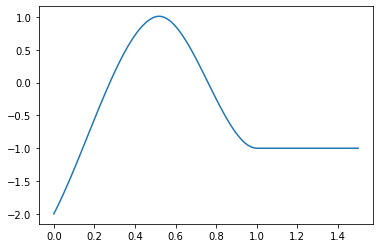

In [19]:
plot_spline(spline, xlim=(0, 1.5))

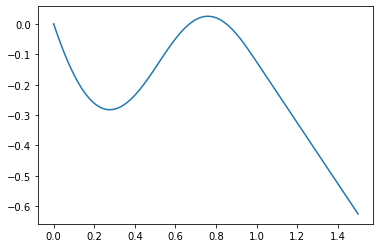

In [20]:
sbml_doc = libsbml.SBMLReader().readSBML('example_splines.xml')
sbml_model = sbml_doc.getModel()
spline.add_to_sbml_model(sbml_model)
simulate(sbml_model, T=1.5);

And here we have a periodic spline.

In [21]:
spline = amici.splines.CubicHermiteSpline(
    sbml_id='f',
    x=amici.sbml_utils.amici_time_symbol,
    xx=amici.splines.UniformGrid(0, 1, length=3),
    yy=[-2, 1, -2], # first and last node must coincide
    extrapolate='periodic',
)

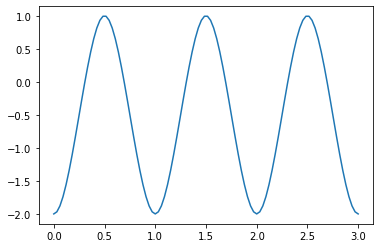

In [22]:
plot_spline(spline, xlim=(0, 3))

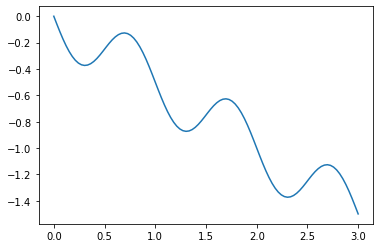

In [23]:
sbml_doc = libsbml.SBMLReader().readSBML('example_splines.xml')
sbml_model = sbml_doc.getModel()
spline.add_to_sbml_model(sbml_model)
simulate(sbml_model, T=3);

Even if all node values are positive, due to under-shooting a cubic Hermite spline can assume negative values. In certain settings (e.g., when the spline represents a chemical reaction rate) this should be avoided. A possible solution is to carry out the interpolation in log-space (the resulting function is no longer a spline, but it is still a smooth interpolant).

In [24]:
spline = amici.splines.CubicHermiteSpline(
    sbml_id='f',
    x=amici.sbml_utils.amici_time_symbol,
    xx=amici.splines.UniformGrid(0, 1, length=5),
    yy=[2, 0.05, 0.1, 2, 1],
)

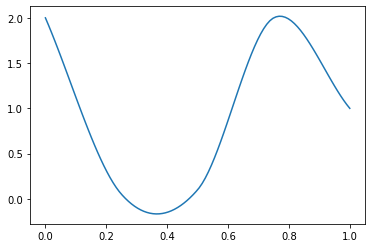

In [25]:
# This spline assumes negative values!
plot_spline(spline)

In [26]:
spline = amici.splines.CubicHermiteSpline(
    sbml_id='f',
    x=amici.sbml_utils.amici_time_symbol,
    xx=amici.splines.UniformGrid(0, 1, length=5),
    yy=[2, 0.05, 0.1, 2, 1],
    logarithmic_parametrization=True,
)

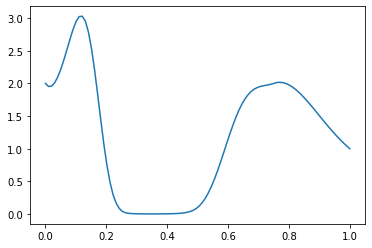

In [27]:
# Instead of under-shooting we now have over-shooting,
# but at least the "spline" is always positive
plot_spline(spline)